# Challenge : predict conversions

## Import libraries

In [116]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.io as pio

# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display


## Read file with labels

In [117]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [118]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


## PART 1 - Explore dataset

In [119]:
# Sample of the dataset before visualizations
data_sample = data.sample(10000)

A- Description dataset

In [120]:
data_sample.describe(include="all")

# no missing values but some outliers regarding the features "age" and "total_pages_visited"

,country,age,new_user,source,total_pages_visited,converted
count,10000,10000.000000,10000.000000,10000,10000.00000,10000.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,5655,NaN,NaN,4864,NaN,NaN
mean,NaN,30.487500,0.682300,NaN,4.94490,0.033600
std,NaN,8.307319,0.465605,NaN,3.35571,0.180206
min,NaN,17.000000,0.000000,NaN,1.00000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.00000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.00000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.00000,0.000000


B- Outliers

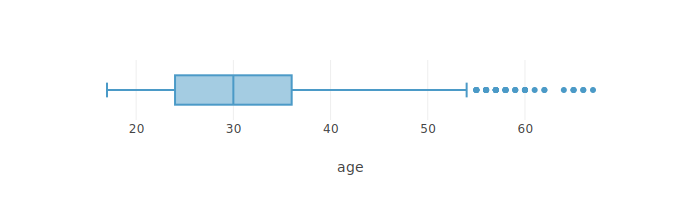

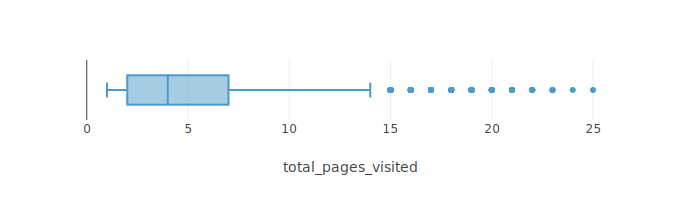

In [121]:
# checking the outliers more precisely
fig = px.box(data_sample, x='age', height=200)
fig.show()
fig = px.box(data_sample, x='total_pages_visited', height=200)
fig.show()

# the significant size of the global dataset allows us to cancel rows with outliers

In [122]:
mask1 = data_sample["age"] <= (data_sample["age"].mean() + 3 * data_sample["age"].std())
mask2 = data_sample["total_pages_visited"] <= (data_sample["total_pages_visited"].mean() + 3 * data_sample["total_pages_visited"].std())
data_sample = data_sample.loc[mask1 & mask2, :]

In [123]:
print("{} rows have been removed form the sample dataset".format(10000-data_sample.shape[0]))

193 rows have been removed form the sample dataset


C- Types of data

In [124]:
data.info()

# confirmation that there is no missing values
# two variables are string and four variables are integers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


D- Univariate analysis

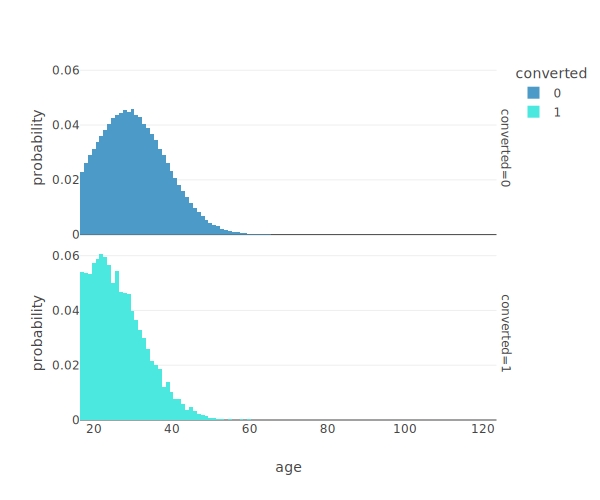

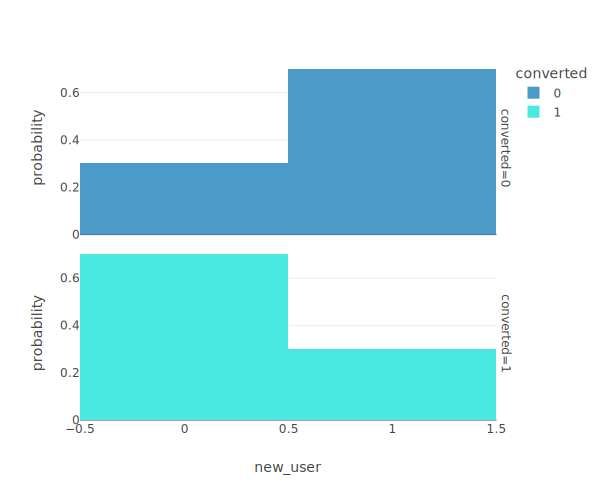

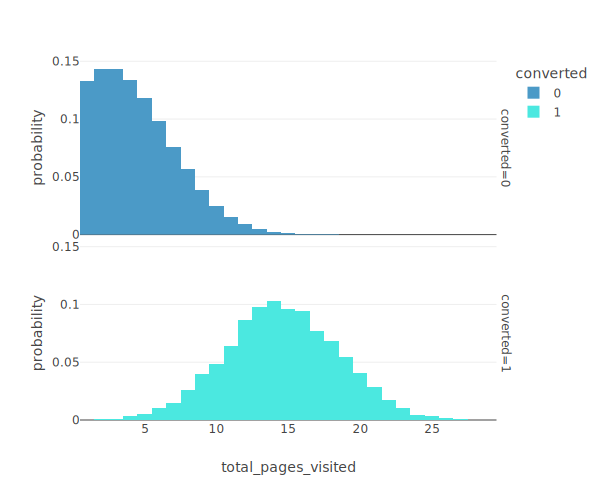

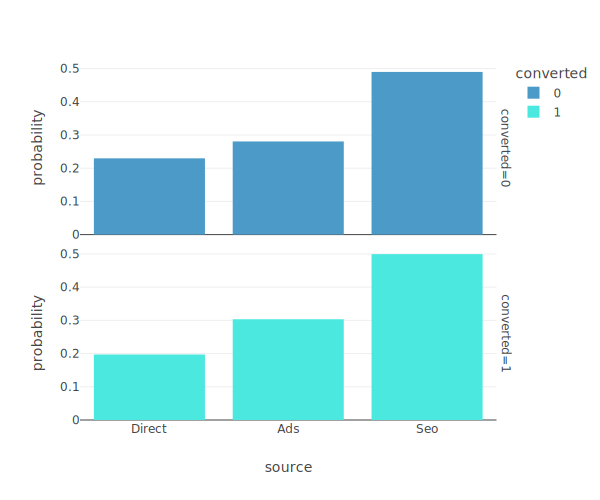

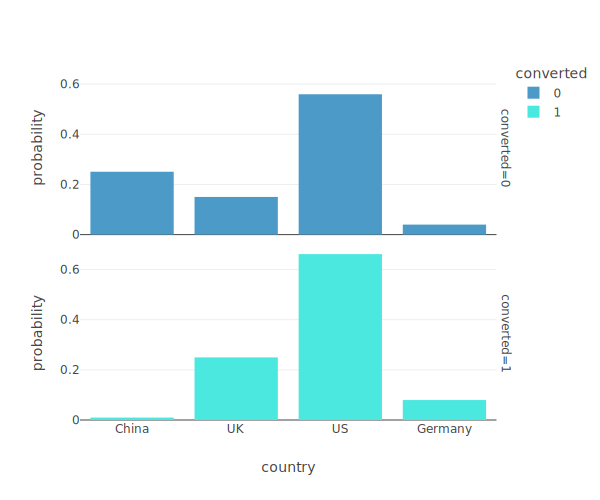

In [125]:
for variable in ["age", "new_user", "total_pages_visited","source","country"] :
    fig = px.histogram(data, x=variable, color = "converted", width=600, facet_row="converted", histnorm="probability")
    fig.show()

we can conclude that :
- the number of pages visited is a good indicator of conversion or not, the greater the number of pages visited, the more likely conversion is
- the notion of customer is also quite discriminatory, converted people being rather new users
- age seems to be a less discriminating criterion even if we note that the converts are generally rather young
- the "country" variable is not very discriminating. there is no real difference between converted or not depending on origin except for the Chinese
- the notion of source does not provide any element in detection

E- Distribution of the target variable

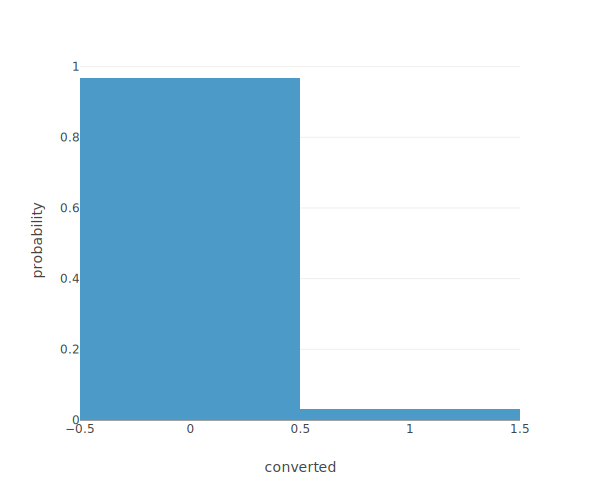

In [126]:
fig = px.histogram(data, x="converted", width=600, histnorm="probability")
fig.show()

** The distribution of the target variable is very unbalanced. \
So, the accuracy score won't be a good way to assess the performance of our model. Indeed, with this kind of score, a dummy model predicting always a no conversion will have a good score.

## PART 2 - MULTIVARIATE LOGISTIC REGRESSION WITH GLOBAL DATASET

In [127]:
# data selection
target_variable = 'converted'
X = data.loc[:,['age', 'new_user', 'total_pages_visited', 'country']]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['age', 'new_user', 'total_pages_visited', 'country'], dtype='object')



In [128]:
X.shape, Y.shape

((284580, 4), (284580,))

In [129]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [130]:
X_train.shape, X_test.shape

((256122, 4), (28458, 4))

A- Training pipeline

In [131]:
# preprocessing
cat_features = ["country", "new_user"]
cat_transformer = OneHotEncoder(drop="first")

num_features = ["age","total_pages_visited"]
num_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer,num_features),
    ("cat", cat_transformer, cat_features)
])

In [132]:
print("Starting preprocessing on train set .....")
X_train = preprocessor.fit_transform(X_train)
print("...Done")
print(X_train[0:5])

Starting preprocessing on train set .....
...Done
[[-0.91458053 -0.85939501  0.          0.          0.          0.        ]
 [-0.30994956 -0.85939501  0.          0.          0.          0.        ]
 [-0.06809718  0.63639894  0.          0.          0.          1.        ]
 [ 0.77838618 -0.56023622  0.          1.          0.          1.        ]
 [ 0.05282902  0.93555773  0.          0.          1.          1.        ]]


In [133]:
# Train model
print("Train model...")
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [134]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



B- Test pipeline

In [135]:
print("Encoding categorical features and standardizing numerical features...")
X_test = preprocessor.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.79365434  2.73051047  0.          0.          0.          1.        ]
 [ 0.53653379  0.03808136  0.          0.          1.          0.        ]
 [-0.18902337 -0.26107743  0.          0.          1.          0.        ]
 [ 0.05282902  0.93555773  0.          0.          0.          1.        ]
 [-0.30994956 -0.85939501  0.          0.          1.          1.        ]]


In [136]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



C- Performance assessment

In [137]:
# As explain, the f1-score will be used to assess the performances
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred).round(3))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred).round(3))

# Performances are quite close on the two datasets.

f1-score on train set :  0.764
f1-score on test set :  0.758


In [138]:
# Creation of a summary table of results by model
model_results = pd.DataFrame.from_dict({
    "Model" :["Multivariate Logistic_regression"] ,
    "Train_set" : [f1_score(Y_train, Y_train_pred).round(3)],
    "Test_set" : [f1_score(Y_test, Y_test_pred).round(3)]
    })
model_results

,Model,Train_set,Test_set
0,Multivariate Logistic_regression,0.764,0.758


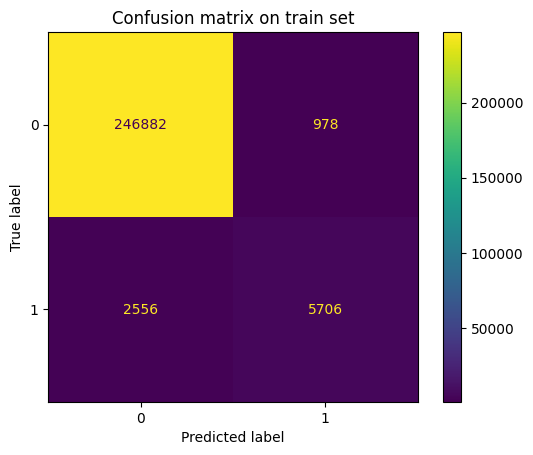

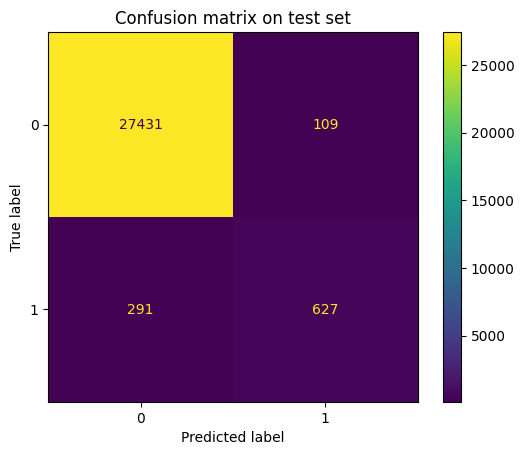

In [139]:
# We also check performance through the Confusion matrix
_,ax = plt.subplots()
ax.set(title="Confusion matrix on train set")
ConfusionMatrixDisplay.from_estimator(classifier, X_train, Y_train, ax=ax)
plt.show()

_,ax = plt.subplots()
ax.set(title="Confusion matrix on test set")
ConfusionMatrixDisplay.from_estimator(classifier, X_test, Y_test, ax=ax)
plt.show()

**Our baseline model reaches a f1-score of almost 76% which is not very high. Our model has some difficulties to detect conversion, doing a lot of mistakes.
Score on train set and test set are very closed.**

D- Regularisation and Hyperparameters optimisation

In [140]:
# we used gridsearch with different values of the parameter C (penalty) and a cross validation of 10
classifier = LogisticRegression(max_iter=1000)
params = {
    "C" : [0.01, 0.1, 0.25, 0.4, 0.6, 0.8]
}
grid = GridSearchCV(classifier, param_grid = params, scoring = "f1", cv=10)
grid.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.01, 0.1, 0.25, 0.4, 0.6, 0.8]}, scoring='f1')

In [141]:
# Predictions
Y_train_pred = grid.predict(X_train)
Y_test_pred = grid.predict(X_test)

In [142]:
# performance assessment
print("Best parameter : ", grid.best_params_)
print("Best F1 score :", f1_score(Y_train, Y_train_pred).round(3))
print("F1 score on test set :", f1_score(Y_test, Y_test_pred).round(3))

Best parameter :  {'C': 0.6}
Best F1 score : 0.763
F1 score on test set : 0.758


In [147]:
encoded_cols = list(preprocessor.get_feature_names_out(X.columns))

In [148]:
# Analysis of feature importance
features_analysis = pd.DataFrame(index=encoded_cols, data = grid.best_estimator_.coef_.transpose(), columns=["Coefs"])
features_analysis

,Coefs
num__age,-0.601450
num__total_pages_visited,2.544822
cat__country_Germany,3.529599
cat__country_UK,3.338221
cat__country_US,2.983481
cat__new_user_1,-1.715667


In [ ]:
# add result to the summary table
result = pd.DataFrame([["Optimised_Logistic_regression",f1_score(Y_train, Y_train_pred).round(3),f1_score(Y_test, Y_test_pred).round(3)]], columns=['Model','Train_set','Test_set'])

In [ ]:
model_results = pd.concat([model_results, result], ignore_index=True)
model_results

,Model,Train_set,Test_set
0,Multivariate Logistic_regression,0.764,0.758
1,Optimised_Logistic_regression,0.763,0.758


H- Univariate model

In [ ]:
# our analysis of the variables showed that correlations between explanatory variables and the target variable were very light,
# a part from the "total_pages_visited" used in the baseline model with one feature
# we propose so to try a logisistic regression with only one variable, the main one ("total_pages_visited")

# Selection des données
X = data.loc[:,["total_pages_visited"]]
Y = data.loc[:, "converted"]
X.head()

# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train_univ, X_test_univ, Y_train_univ, Y_test_univ = train_test_split(X, Y, test_size=0.1, random_state=0, stratify=Y)
print("...Done.")
print()

# preprocessing
num_features = ["total_pages_visited"]
num_transformer = StandardScaler()

print("début du preprocessing sur le jeu d'entrainement :")
X_train_univ = num_transformer.fit_transform(X_train_univ)
print("...Done")
print("Encoding categorical features and standardizing numerical features...")
X_test_univ = num_transformer.transform(X_test_univ)
print("...Done")

# Train model
print("Train model...")
classifier_univariate = LogisticRegression()
classifier_univariate.fit(X_train_univ, Y_train_univ)
print("...Done.")

# Predictions
print("Predictions on training set...")
Y_train_pred = classifier_univariate.predict(X_train_univ)
print("...Done.")
print("Predictions on training set...")
Y_test_pred = classifier_univariate.predict(X_test_univ)
print("...Done.")

# Performance assessment
print("f1-score on train set : ", f1_score(Y_train_univ, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test_univ, Y_test_pred))

Dividing into train and test sets...


...Done.

début du preprocessing sur le jeu d'entrainement :
...Done
Encoding categorical features and standardizing numerical features...
...Done
Train model...
...Done.
Predictions on training set...
...Done.
Predictions on training set...
...Done.
f1-score on train set :  0.6971029668411867
f1-score on test set :  0.6771951989892608


The performance of the model is significantly less good with only one feature.

## PART 3 - RANDOM FOREST WITH OPTIMISATION

A- Train model

In [ ]:
print("Starting Grid Search ......")
random_forest = RandomForestClassifier()
params = {
    "max_depth" : [5,8,10],
    "min_samples_leaf" : [1,2,5,6],
    "min_samples_split" : [2,4,6],
    "n_estimators" : [10,20,40,60,80]
}
grid_random = GridSearchCV(random_forest, param_grid=params, scoring="f1", cv=3, n_jobs=-1)
grid_random.fit(X_train, Y_train)
print("......Done.")

Starting Grid Search ......
......Done.


In [ ]:
print("Best parameters : ", grid_random.best_params_)

Best parameters :  {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 80}


In [ ]:
# Predictions on train and test set
print("Predictions on training set...")
Y_train_pred = grid_random.predict(X_train)
print("...Done.")
print("Predictions on test set...")
Y_test_pred = grid_random.predict(X_test)
print("...Done.")

Predictions on training set...
...Done.
Predictions on test set...
...Done.


B- Performance assessment

In [ ]:
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred).round(3))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred).round(3))

f1-score on train set :  0.769
f1-score on test set :  0.755


In [ ]:
# Enrichissement du tableau de synthèse
result = pd.DataFrame([["Optimised_Random_forest",f1_score(Y_train, Y_train_pred).round(3),f1_score(Y_test, Y_test_pred).round(3)]], columns=['Model','Train_set','Test_set'])
model_results = pd.concat([model_results,result], ignore_index=True)
model_results

,Model,Train_set,Test_set
0,Multivariate Logistic_regression,0.764,0.758
1,Optimised_Logistic_regression,0.763,0.758
2,Optimised_Random_forest,0.769,0.755


There is no really improvment in the performance at this point.

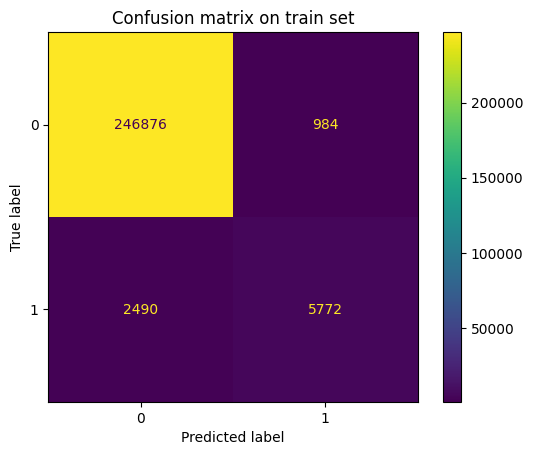

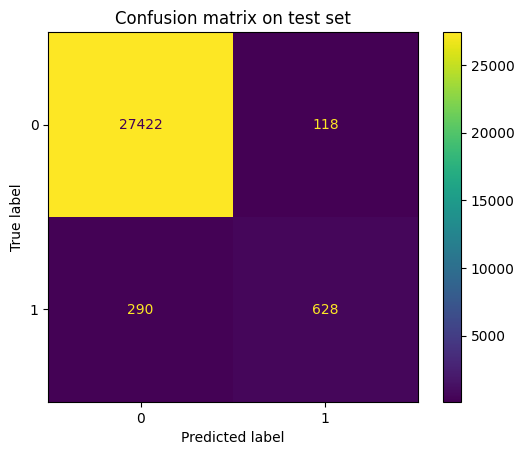

In [ ]:
# We also check performance through the Confusion matrix
_,ax = plt.subplots()
ax.set(title="Confusion matrix on train set")
ConfusionMatrixDisplay.from_estimator(grid, X_train, Y_train, ax=ax)
plt.show()

_,ax = plt.subplots()
ax.set(title="Confusion matrix on test set")
ConfusionMatrixDisplay.from_estimator(grid, X_test, Y_test, ax=ax)
plt.show()

## PART 4 - Train best classifier on all data and use it to make predictions on X_without_labels
Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [ ]:
# Concatenate our train and test set to train your best classifier on all data with labels
X_global = np.append(X_train,X_test,axis=0)
Y_global = np.append(Y_train,Y_test)

classifier.fit(X_global,Y_global)

LogisticRegression(max_iter=1000)

In [ ]:
# Read data without labels
X_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', X_without_labels.shape)

X_without_labels.head()

Prediction set (without labels) : (31620, 5)


,country,age,new_user,source,total_pages_visited
0,UK,28,0,Seo,16
1,UK,22,1,Direct,5
2,China,32,1,Seo,1
3,US,32,1,Ads,6
4,China,25,0,Seo,3


In [ ]:
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.30994956  3.32882805  0.          1.          0.          0.        ]
 [-1.03550673  0.03808136  0.          1.          0.          1.        ]
 [ 0.17375521 -1.1585538   0.          0.          0.          1.        ]
 [ 0.17375521  0.33724015  0.          0.          1.          1.        ]
 [-0.67272814 -0.56023622  0.          0.          0.          0.        ]]


In [ ]:
X_without_labels.shape

(31620, 6)

In [ ]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_DuplandSylvain-model1.csv', index=False)


## Part - 5 Analyzing the coefficients and interpreting the result

At least, the logistic regression model with all the features gives the best results at a first look.

In order to improve the model performance, we could try to get new features linked to the customer profile.

For example the kind of pages visited (subjects), or the time stayed on the website.